# House Price Prediction Using Regression Analysis

## 1. Importing Modules and Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

In [2]:
# Library data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


# Warnings remove alerts
import warnings
warnings.filterwarnings("ignore")

## 2. Loading the Datasets

In [3]:
# Load the Datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
# Checking the number of rows and columns in the DataFrame
r, c = df_train.shape
print(f'The training data has {r} rows and {c} columns')
r, c = df_test.shape
print(f'The validation data has {r} rows and {c} columns')

The training data has 1460 rows and 81 columns
The validation data has 1459 rows and 80 columns


In [5]:
# Viewing first 5 data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Viewing first 5 test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Cleaning the Datasets

In [7]:
# Function to clean data (based on EDA cleaning)
def clean_data(df):
    # Drop columns with >80% missing values
    missing_values = df.isnull().sum()
    high_missing_cols = missing_values[missing_values > 0.8 * len(df)].index
    df_cleaned = df.drop(columns=high_missing_cols)

    # Impute Missing Values for Columns with Moderate Missing Values (5-80%)
    moderate_missing_cols = missing_values[(missing_values > 0.05 * len(df)) & (missing_values <= 0.8 * len(df))].index
    num_moderate_cols = [col for col in moderate_missing_cols if df[col].dtype in ['int64', 'float64']]
    cat_moderate_cols = [col for col in moderate_missing_cols if df[col].dtype == 'object']
    imputer_num = SimpleImputer(strategy='median')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_cleaned[num_moderate_cols] = imputer_num.fit_transform(df_cleaned[num_moderate_cols])
    df_cleaned[cat_moderate_cols] = imputer_cat.fit_transform(df_cleaned[cat_moderate_cols])

    # Impute Missing Values for Columns with Low Missing Values (<5%)
    low_missing_cols = missing_values[(missing_values > 0) & (missing_values <= 0.05 * len(df))].index
    num_low_cols = [col for col in low_missing_cols if df[col].dtype in ['int64', 'float64']]
    cat_low_cols = [col for col in low_missing_cols if df[col].dtype == 'object']
    df_cleaned[num_low_cols] = imputer_num.fit_transform(df_cleaned[num_low_cols])
    df_cleaned[cat_low_cols] = imputer_cat.fit_transform(df_cleaned[cat_low_cols])

    return df_cleaned


In [8]:
# Clean the datasets
df_train_cleaned = clean_data(df_train)
df_test_cleaned = clean_data(df_test)

In [9]:
# Check for missing values in cleaned data
df_train_cleaned.isnull().sum().sum()

0

## 4. Data Visualization


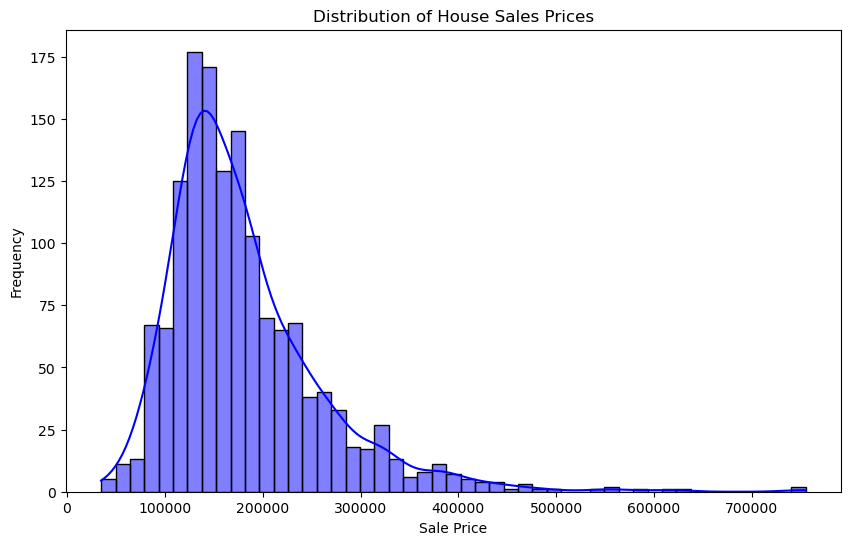

In [10]:
### Distribution of Target Variable (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(df_train_cleaned['SalePrice'], kde=True, color='blue')
plt.title('Distribution of House Sales Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

- This histogram shows the distribution of the target variable, `SalePrice`. 
- The KDE (Kernel Density Estimate) line provides a smoothed estimate of the data distribution.
- The distribution is slightly right-skewed, indicating that most houses are clustered in the lower price range.

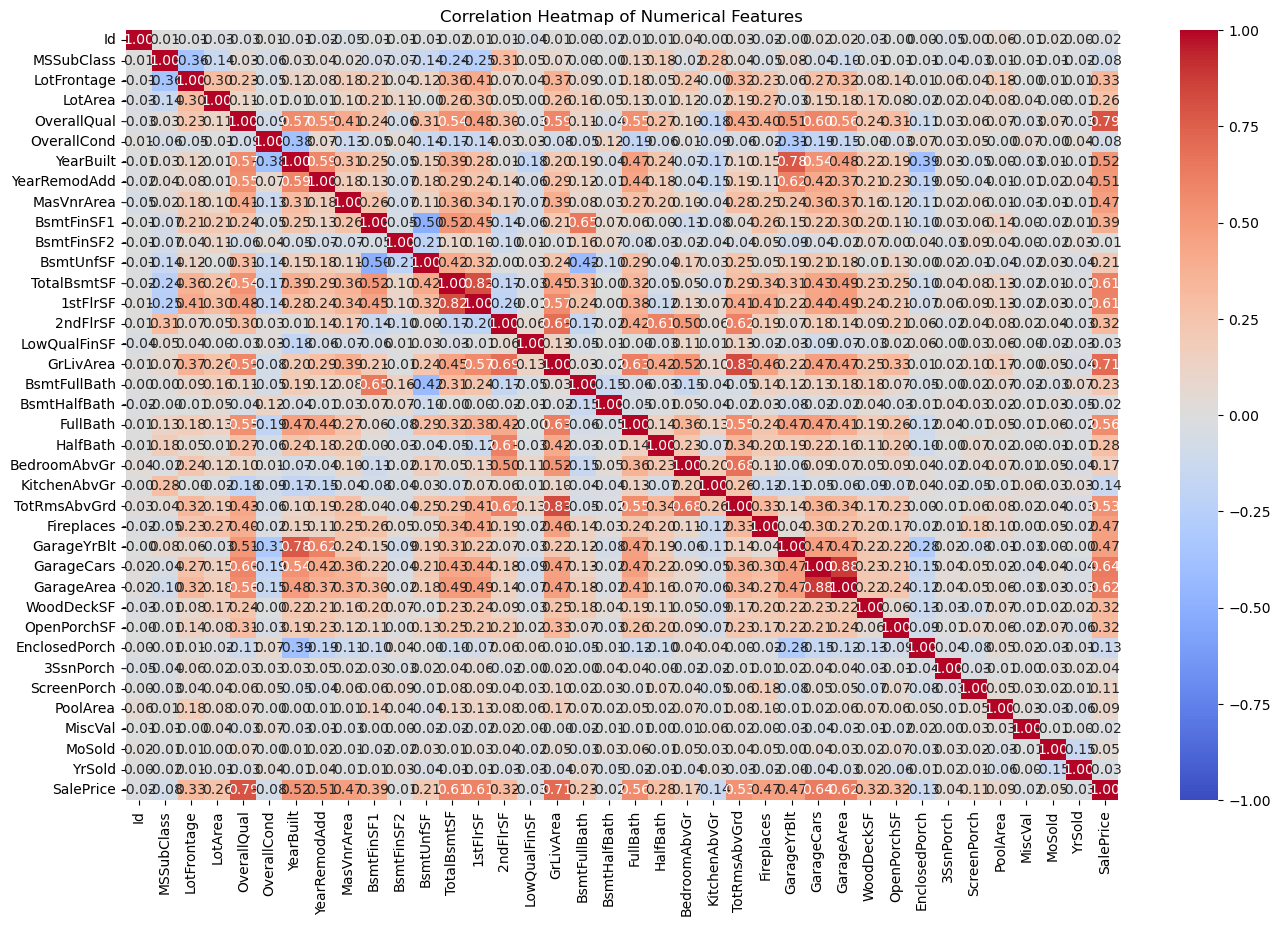

In [11]:
# Ensure you are only selecting numerical columns
numeric_df = df_train_cleaned.select_dtypes(include=[np.number])

# Now compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


- This heatmap visualizes the correlation between numerical features in the dataset. 
- A value close to 1 or -1 indicates a strong correlation, either positive or negative, respectively. 
- Features like `OverallQual`, `GrLivArea`, and `GarageCars` show high correlation with `SalePrice`.


## Visualizing Important Features Against SalePrice

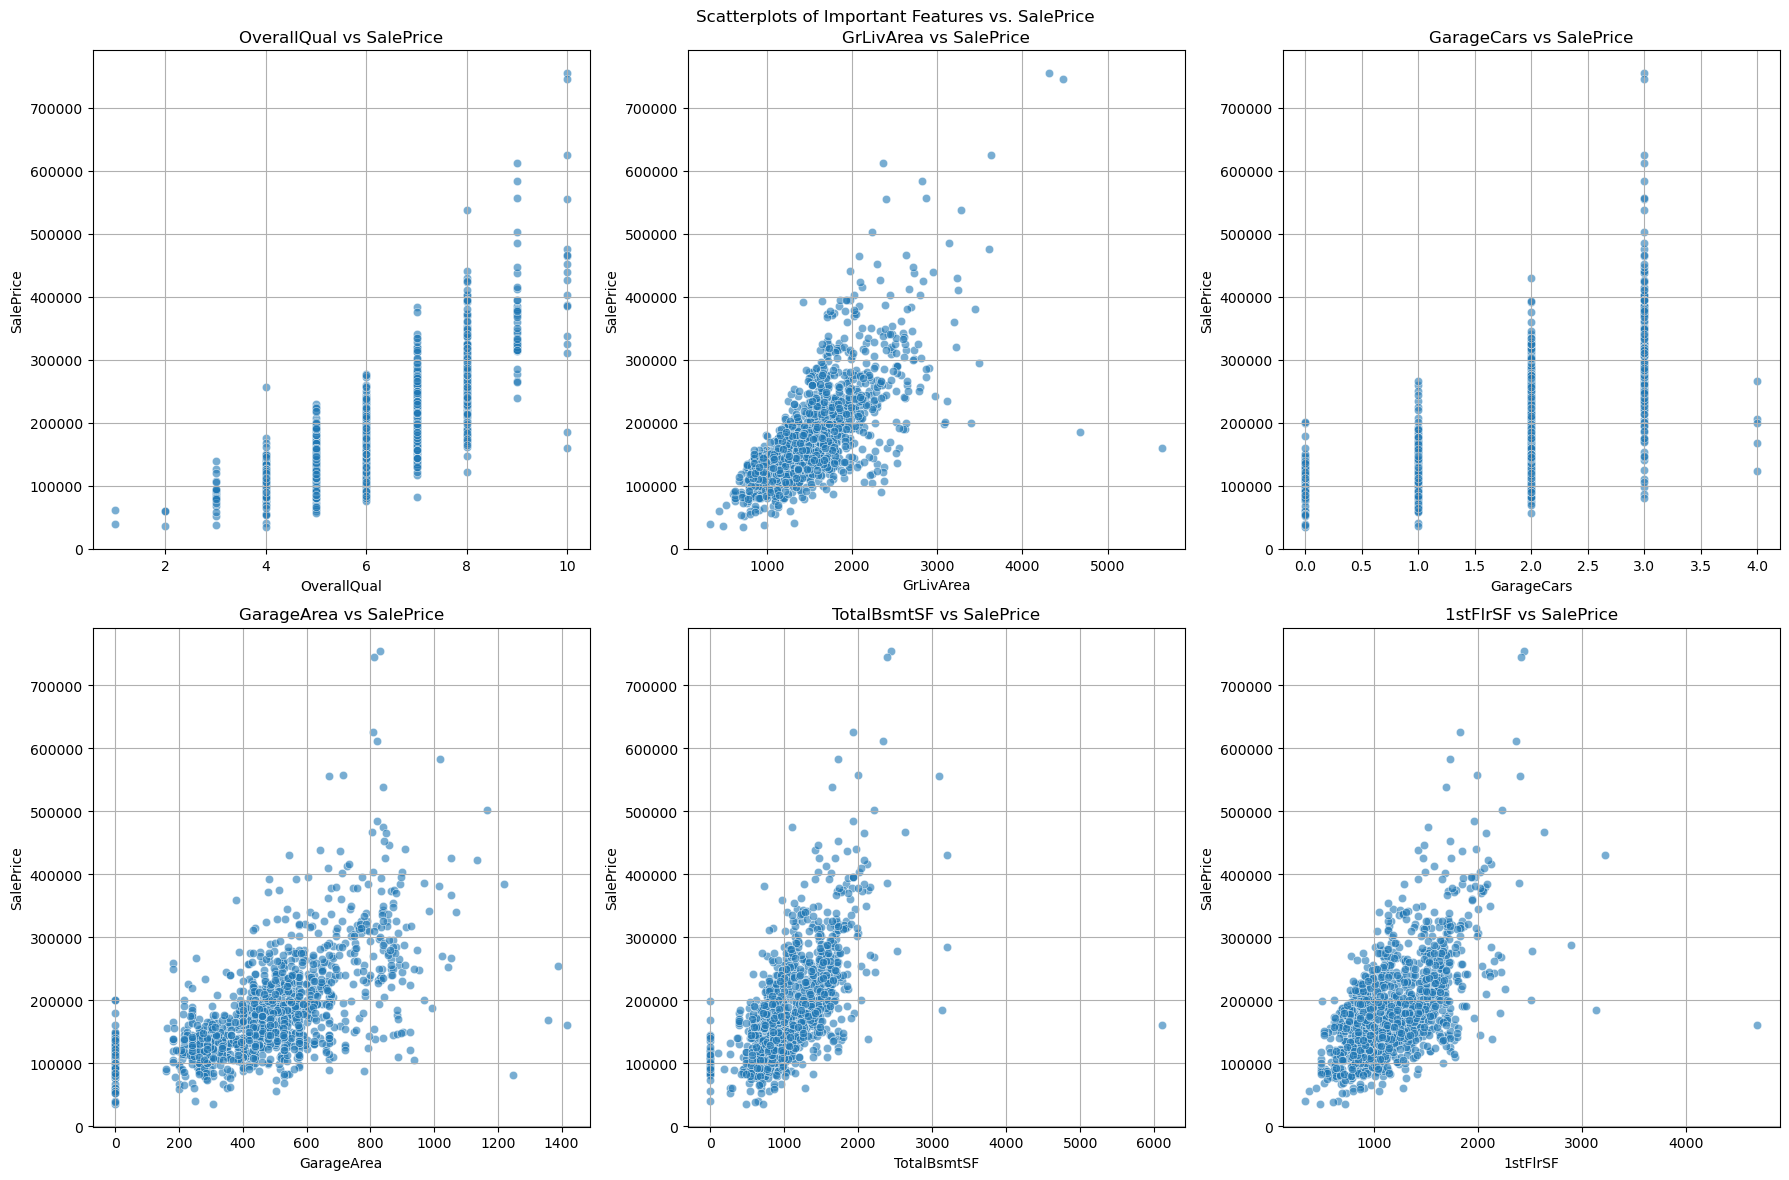

In [12]:
important_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Scatterplots of Important Features vs. SalePrice')

for i, feature in enumerate(important_features):
    sns.scatterplot(ax=axes[i//3, i%3], x=feature, y='SalePrice', data=df_train_cleaned, alpha=0.6)
    axes[i//3, i%3].set_title(f'{feature} vs SalePrice')
    axes[i//3, i%3].grid(True)

plt.tight_layout()
plt.show()

- These scatterplots illustrate the relationship between `SalePrice` and several important features like `OverallQual`, 
- `GrLivArea`, and `GarageCars`. Each plot helps to visually confirm the correlations observed in the heatmap.
- For instance, houses with higher `OverallQual` tend to have higher `SalePrice`.

## Visualizing Categorical Features with SalePrice

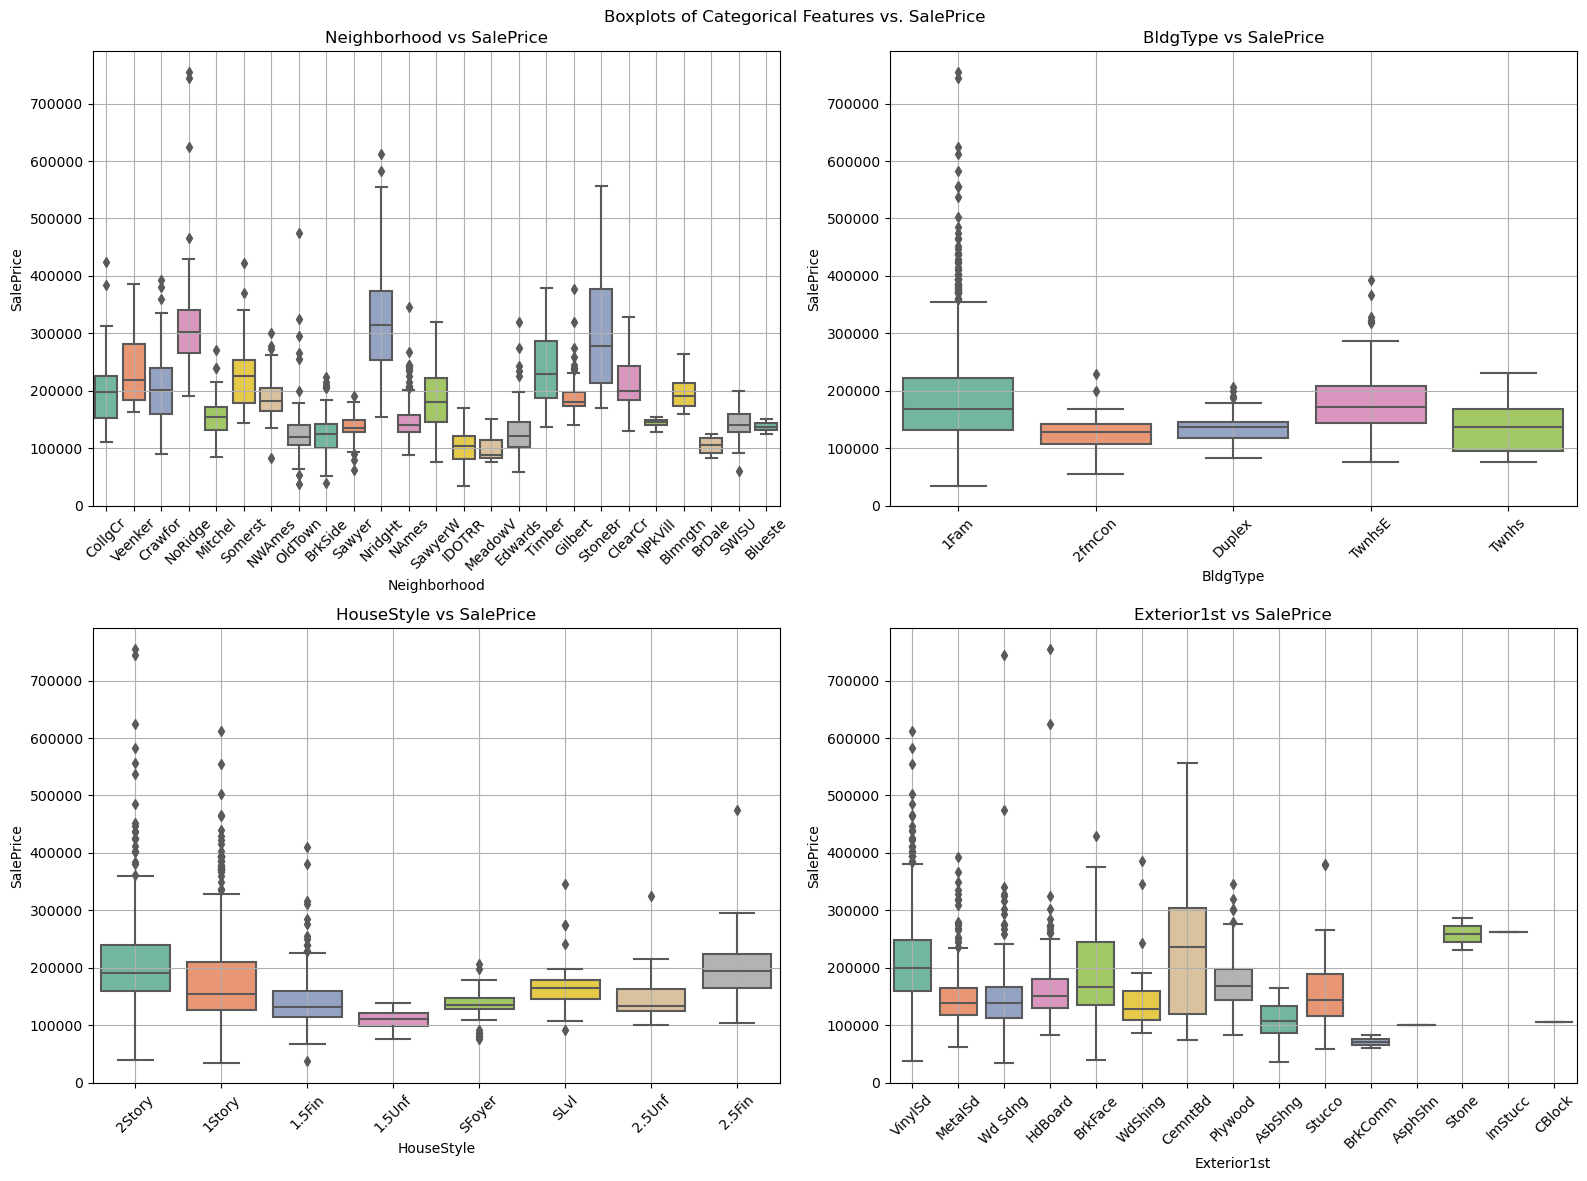

In [13]:
categorical_features = ['Neighborhood', 'BldgType', 'HouseStyle', 'Exterior1st']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Boxplots of Categorical Features vs. SalePrice')

for i, feature in enumerate(categorical_features):
    sns.boxplot(ax=axes[i//2, i%2], x=feature, y='SalePrice', data=df_train_cleaned, palette='Set2')
    axes[i//2, i%2].set_title(f'{feature} vs SalePrice')
    axes[i//2, i%2].tick_params(axis='x', rotation=45)
    axes[i//2, i%2].grid(True)

plt.tight_layout()
plt.show()

- Boxplots are used to explore the distribution of `SalePrice` across different categories, such as `Neighborhood` and `BldgType`.
- They help to identify the variation in prices within each category and how some categories, like `Neighborhood`, 
- might have a significant impact on the price.

## 5. Feature Engineering and Data Preparation

In [14]:
# Extract target variable and remove it from training data
Y_Train = df_train_cleaned['SalePrice']
X_Train = df_train_cleaned.drop(columns=['SalePrice', 'Id'])

# Combine training and test data for consistent preprocessing
df_combined = pd.concat([X_Train, df_test_cleaned.drop(columns=['Id'])]).reset_index(drop=True)

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
object_cols = df_combined.select_dtypes(include='object').columns
encoded_features = pd.DataFrame(encoder.fit_transform(df_combined[object_cols]))
encoded_features.index = df_combined.index
encoded_features.columns = encoder.get_feature_names_out()

# Combine encoded features with the original data
df_final = df_combined.drop(object_cols, axis=1)
df_final = pd.concat([df_final, encoded_features], axis=1)

# Separate the combined data back into training and test sets
X_Train = df_final.iloc[:len(df_train_cleaned)]
X_Test = df_final.iloc[len(df_train_cleaned):]

# Split the training data into training and validation sets
X_train, X_valid, Y_train, Y_valid = train_test_split(X_Train, Y_Train, train_size=0.8, test_size=0.2, random_state=42)


## 6. Model Training and Evaluation

In [15]:
# Function to build and evaluate models
def build_and_evaluate(models):
    results = {}
    for name, model in models.items():
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_valid)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred))
        r2 = r2_score(Y_valid, Y_pred)
        mae = mean_absolute_error(Y_valid, Y_pred)
        
        # Store results
        results[name] = {'RMSE': rmse, 'R-squared': r2, 'MAE': mae}
    return results

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = build_and_evaluate(models)

In [16]:
# Display the evaluation results
results_df = pd.DataFrame(results).T
print(results_df)

                           RMSE  R-squared           MAE
Linear Regression  29773.443312   0.884430  18409.348887
Ridge Regression   29372.909022   0.887519  19003.044096
Lasso Regression   28391.417949   0.894910  18006.094907
Decision Tree      39721.735535   0.794296  26519.606164
Random Forest      28742.692548   0.892294  17528.441849
Gradient Boosting  26736.548806   0.906804  16567.315820
XGBoost            26654.078483   0.907378  17028.295658


- This table shows the performance of different models on the validation set using three metrics: RMSE, R-squared, and MAE.
- The `XGBoost` model typically performs well, and you can identify the best model based on the lowest RMSE.


## 7. Model Comparison

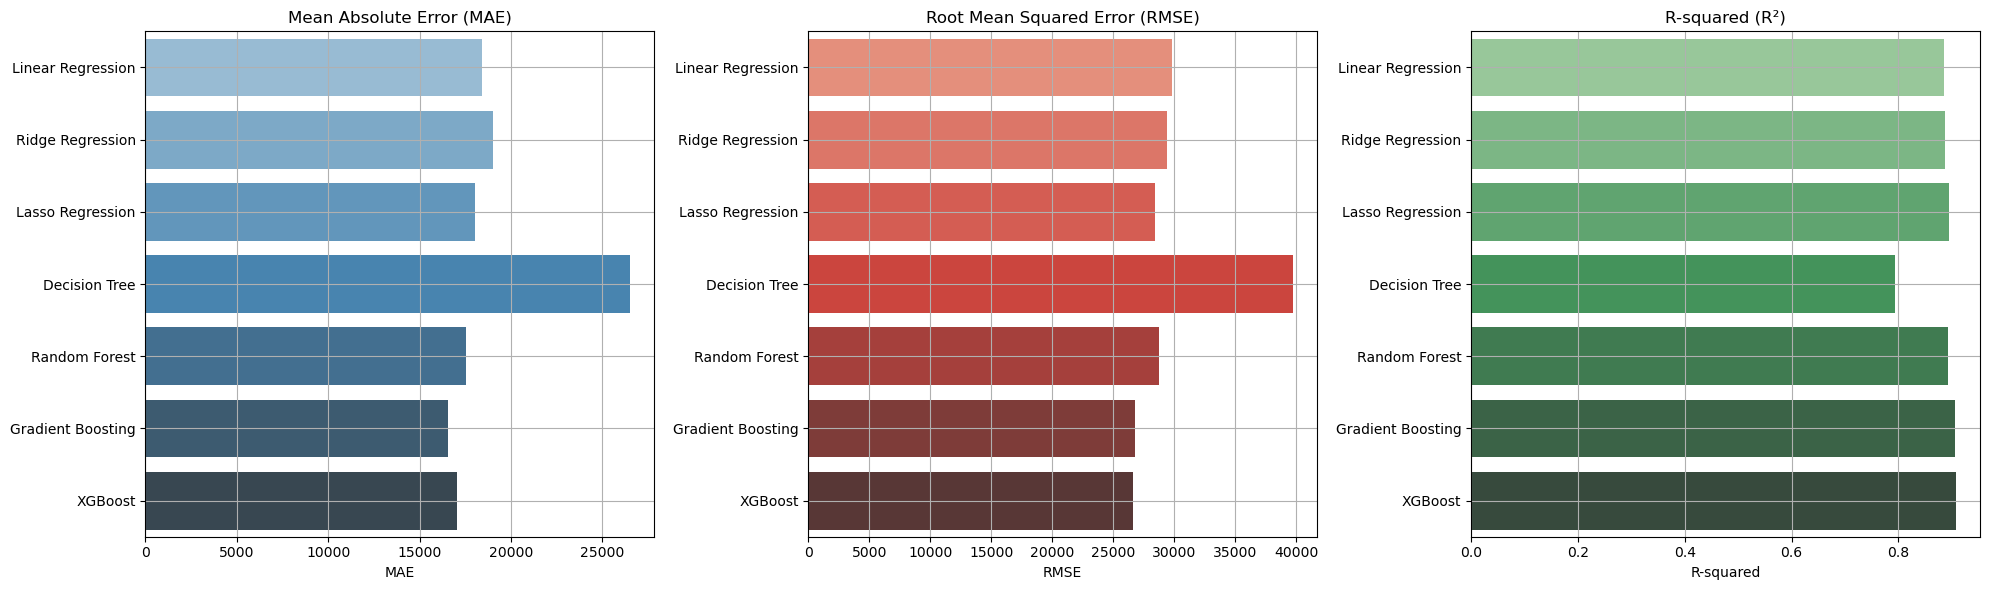

In [17]:
# Bar charts for comparison of MAE, RMSE, and R²
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(y=results_df.index, x=results_df['MAE'], ax=axes[0], palette='Blues_d')
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].grid(True)

sns.barplot(y=results_df.index, x=results_df['RMSE'], ax=axes[1], palette='Reds_d')
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].grid(True)

sns.barplot(y=results_df.index, x=results_df['R-squared'], ax=axes[2], palette='Greens_d')
axes[2].set_title("R-squared (R²)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

- These bar plots visualize the performance of each model in terms of MAE, RMSE, and R².
- They provide a clear visual comparison, highlighting which model performs best according to each metric.
- For example, the model with the lowest RMSE (typically `XGBoost`) would be considered the best.

## 8. Feature Importance (for Tree-based Models)

The best model before tuning is XGBoost with RMSE: 26654.078483037967


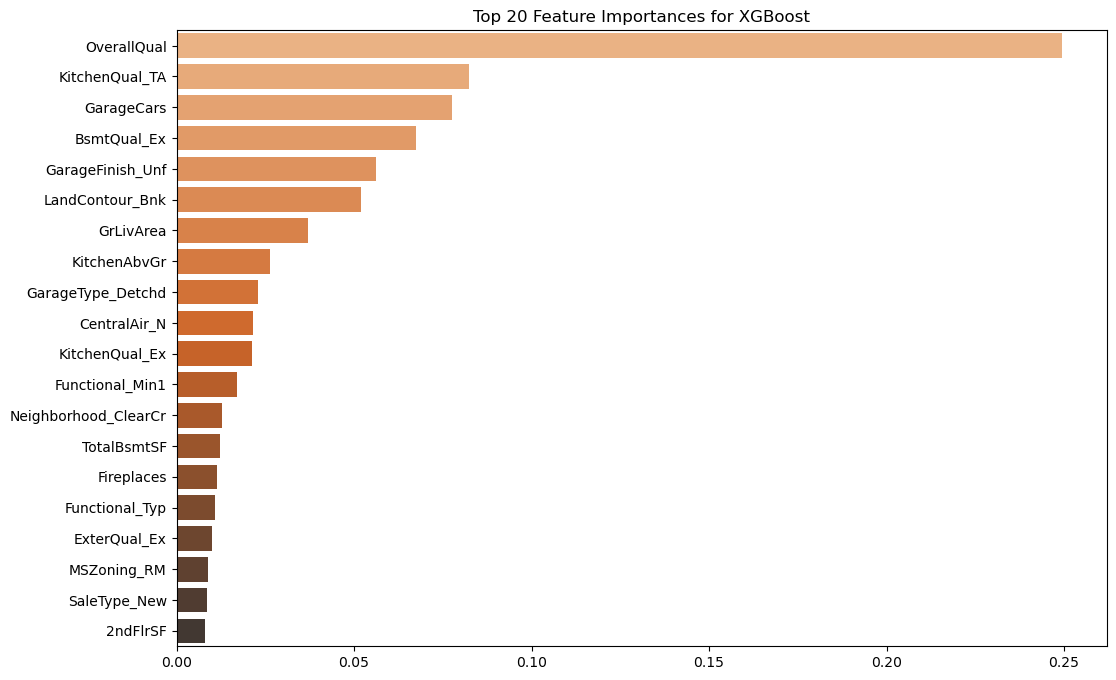

In [18]:
# Feature importance for Best Model
best_model_name = results_df['RMSE'].idxmin()
print(f"The best model before tuning is {best_model_name} with RMSE: {results_df.loc[best_model_name, 'RMSE']}")

best_model = models[best_model_name]
best_model.fit(X_train, Y_train)
feature_importances = best_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_indices[:20]], y=X_train.columns[sorted_indices[:20]], palette='Oranges_d')
plt.title(f'Top 20 Feature Importances for {best_model_name}')
plt.show()

- This bar plot displays the top 20 most important features used by the best-performing model (e.g., `XGBoost`).
- Feature importance scores indicate how much a particular feature contributes to the model's predictions.
- Higher importance indicates a greater impact on predicting `SalePrice`.

## 9. Hyperparameter Tuning and Model Training

In [19]:
# Define the hyperparameter grid 
param_grids = {
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    "Ridge": {
        'alpha': [0.1, 1.0, 10.0],
        'solver': ['auto', 'svd', 'cholesky', 'lsqr']
    },
    "Decision Tree": {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    "Lasso": {
        'alpha': [0.1, 1.0, 10.0],
        'max_iter': [1000, 2000, 5000]
    }
}

# Ensure that the right parameters are passed to the correct model
param_grid = param_grids.get(best_model_name, {})

# Perform hyperparameter tuning
random_search = RandomizedSearchCV(
    best_model,
    param_grids[best_model_name],
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, Y_train)
best_model_tuned = random_search.best_estimator_

In [20]:
# Final evaluation on the validation set with the best model after tuning
final_Y_pred = best_model_tuned.predict(X_valid)
final_mae = mean_absolute_error(Y_valid, final_Y_pred)
final_rmse = np.sqrt(mean_squared_error(Y_valid, final_Y_pred))
final_r2 = r2_score(Y_valid, final_Y_pred)

print(f"Final {best_model_name} Model Performance after Hyperparameter Tuning:")
print(f"  MAE: {final_mae:.2f}")
print(f"  RMSE: {final_rmse:.2f}")
print(f"  R-squared: {final_r2:.2f}")


Final XGBoost Model Performance after Hyperparameter Tuning:
  MAE: 15879.73
  RMSE: 25322.07
  R-squared: 0.92


- After tuning the hyperparameters of the best model, the updated performance metrics (MAE, RMSE, R²) are displayed.
- The improvements (if any) over the initial model performance indicate the effectiveness of hyperparameter tuning.

## 10. Hybrid Model (Ridge + XGBoost)


In [21]:
# Combine Ridge and XGBoost in a VotingRegressor
ridge_model = Ridge(alpha=1.0, random_state=42)
hybrid_model = VotingRegressor([('ridge', ridge_model), ('xgboost', best_model_tuned)])

# Train the Hybrid Model
hybrid_model.fit(X_train, Y_train)
Y_pred_hybrid = hybrid_model.predict(X_valid)

# Calculate evaluation metrics for the Hybrid Model
hybrid_mae = mean_absolute_error(Y_valid, Y_pred_hybrid)
hybrid_rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred_hybrid))
hybrid_r2 = r2_score(Y_valid, Y_pred_hybrid)

print(f"Initial Hybrid Model Performance:")
print(f"  MAE: {hybrid_mae:.2f}")
print(f"  RMSE: {hybrid_rmse:.2f}")
print(f"  R-squared: {hybrid_r2:.2f}")

Initial Hybrid Model Performance:
  MAE: 15599.49
  RMSE: 25633.17
  R-squared: 0.91


In [22]:
# Hyperparameter tuning for the Hybrid Model
param_grid_hybrid = {
    'ridge__alpha': [0.1, 1.0, 10.0],
    'xgboost__n_estimators': [100, 200],
    'xgboost__learning_rate': [0.01, 0.1],
    'xgboost__max_depth': [3, 4]
}

randomized_search_hybrid = RandomizedSearchCV(hybrid_model, param_grid_hybrid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
randomized_search_hybrid.fit(X_train, Y_train)
hybrid_best_model = randomized_search_hybrid.best_estimator_

In [23]:
# Final evaluation on the validation set with the tuned Hybrid Model
Y_pred_hybrid_final = hybrid_best_model.predict(X_valid)
hybrid_final_mae = mean_absolute_error(Y_valid, Y_pred_hybrid_final)
hybrid_final_rmse = np.sqrt(mean_squared_error(Y_valid, Y_pred_hybrid_final))
hybrid_final_r2 = r2_score(Y_valid, Y_pred_hybrid_final)

print(f"Final Hybrid Model Performance after Hyperparameter Tuning:")
print(f"  MAE: {hybrid_final_mae:.2f}")
print(f"  RMSE: {hybrid_final_rmse:.2f}")
print(f"  R-squared: {hybrid_final_r2:.2f}")

Final Hybrid Model Performance after Hyperparameter Tuning:
  MAE: 15598.55
  RMSE: 25677.76
  R-squared: 0.91


- The hybrid model combines the strengths of `Ridge` and `XGBoost` models. 
- After hyperparameter tuning, the final performance metrics of the hybrid model are displayed.
- This approach can sometimes outperform individual models by leveraging their combined predictive power.

In [24]:
# Update the results DataFrame with the tuned Hybrid Model
results_df.loc['Hybrid Model'] = [hybrid_final_rmse, hybrid_final_r2, hybrid_final_mae]

In [25]:
# Display the updated evaluation results including the Hybrid Model
print(results_df)


                           RMSE  R-squared           MAE
Linear Regression  29773.443312   0.884430  18409.348887
Ridge Regression   29372.909022   0.887519  19003.044096
Lasso Regression   28391.417949   0.894910  18006.094907
Decision Tree      39721.735535   0.794296  26519.606164
Random Forest      28742.692548   0.892294  17528.441849
Gradient Boosting  26736.548806   0.906804  16567.315820
XGBoost            26654.078483   0.907378  17028.295658
Hybrid Model       25677.759054   0.914039  15598.553358


## 11. Final Model Prediction and Submission

In [26]:
# Comparison between the tuned best model and the tuned hybrid model
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'R-squared'],
    best_model_name: [final_mae, final_rmse, final_r2],
    'Hybrid Model': [hybrid_final_mae, hybrid_final_rmse, hybrid_final_r2]
})

print(comparison_df)

      Metric       XGBoost  Hybrid Model
0        MAE  15879.726790  15598.553358
1       RMSE  25322.066828  25677.759054
2  R-squared      0.916404      0.914039


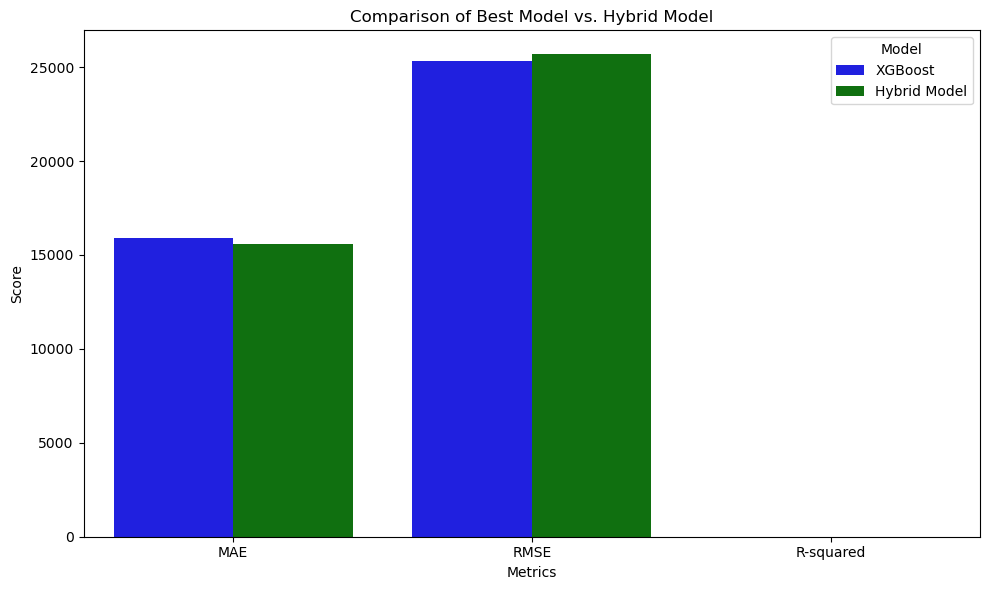

In [29]:
# Updated comparison plot with grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Melting the DataFrame to format suitable for grouped bar plot
comparison_melted = pd.melt(comparison_df, id_vars=['Metric'], var_name='Model', value_name='Score')

# Creating the grouped bar plot
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_melted, ax=ax, palette=['blue', 'green'])

# Customizing the plot
ax.set_title('Comparison of Best Model vs. Hybrid Model')
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.legend(title='Model')

# Display the plot
plt.tight_layout()
plt.show()


- This grouped bar plot compares the performance metrics (MAE, RMSE, R²) of the tuned best model and the tuned hybrid model.
- It allows for an easy visual comparison to determine which model performed better across different metrics.

- Determine the best model based on RMSE

In [28]:
# Determine the best model based on RMSE
if hybrid_final_rmse < final_rmse:
    print(f"The Hybrid Model is the best model with the lowest RMSE of {hybrid_final_rmse:.2f}.")
    best_model = hybrid_best_model
    best_model_name = "Hybrid Model"
else:
    print(f"The {best_model_name} Model is the best model with the lowest RMSE of {final_rmse:.2f}.")
    best_model = best_model_tuned
    
# Make predictions on the test data
Y_Pred_test = best_model.predict(X_Test)

# Prepare the submission file
submission = pd.DataFrame({'Id': df_test_cleaned['Id'], 'SalePrice': Y_Pred_test})
submission.to_csv('submission.csv', index=False)

print(f"Submission file created using the {best_model_name}.")
print(submission.head())

The XGBoost Model is the best model with the lowest RMSE of 25322.07.
Submission file created using the XGBoost.
     Id      SalePrice
0  1461  124189.515625
1  1462  163927.515625
2  1463  175459.625000
3  1464  193267.890625
4  1465  186803.765625


- The final step compares the hybrid model and the tuned best model to determine the overall best model based on RMSE.
- Predictions are made on the test data using the best model, and the results are saved to a CSV file for submission.